###Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Importing Libraries

In [ ]:
import keras
import os
import glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import random
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf

import imageio
from skimage import transform,io

import cv2
from sklearn.utils import shuffle



In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [ ]:
print(keras.__version__)

2.7.0


In [ ]:
print(tf.__version__)

2.7.0


###Ploting Function

In [ ]:

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

###Loading Data

In [ ]:

DATASET_PATH = "/content/drive/MyDrive/Potato & Tomato disease classification/Data/PlantVillage"

### Details of dataset

In [ ]:
disease_cls = os.listdir(DATASET_PATH)
print('List of Classes: ', disease_cls)
print('Number of Classes: ', len(disease_cls))

List of Classes:  ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of Classes:  15


In [ ]:

labels = [x for x in range(len(disease_cls))]
images = []
labels_cls = []
name_cls = []
for i in labels:
    
    temp_path = DATASET_PATH + '/' + disease_cls[i]
    im_list = os.listdir(temp_path)
    for j in im_list:
        temp_path1 = temp_path + '/' + j
        images.append(temp_path1)
        labels_cls.append(i)
        name_cls.append(disease_cls[i])
data = pd.DataFrame()
data['FileName']= images
data['Label']= labels_cls
data['ClassName'] = name_cls
data.shape

(20639, 3)

###Data Spliting

In [ ]:
from sklearn.model_selection import train_test_split

train, val= train_test_split(data, test_size=0.2, shuffle= True, random_state = 100)

In [ ]:
def load_samples(data):
    file_names = list(data.iloc[:,0])
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

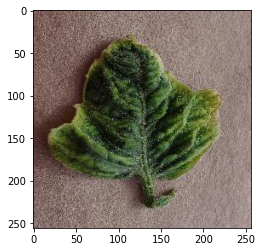

In [ ]:

import random
rand_index = random.randint(0, len(images))
image = io.imread(images[rand_index])
plt.imshow(image)

In [ ]:
print(image.shape)

(256, 256, 3)


### Generator

In [ ]:
num_classes = 15
resize=150
def data_generator(samples, batch_size=32,shuffle_data=True,resize=resize):

    num_samples = len(samples)
    while True: 
        samples = shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            X_train = []
            y_train = []

            for batch_sample in batch_samples:
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(img_name)
                img = cv2.resize(img,(resize,resize))
                img = img/255
                label = np_utils.to_categorical(label, num_classes)

                X_train.append(img)
                y_train.append(label)

            X_train = np.array(X_train)
            y_train = np.array(y_train)
            
            yield X_train, y_train

In [ ]:
train_samples = load_samples(train)
val_samples = load_samples(val)

num_train_samples = len(train_samples)
num_val_samples = len(val_samples)

print ('number of train samples: ', num_train_samples)
print ('number of val samples: ', num_val_samples)

number of train samples:  16511
number of val samples:  4128


In [ ]:

batch_size=1000
train_generator = data_generator(train_samples, batch_size=batch_size)
validation_generator = data_generator(val_samples, batch_size=batch_size)

#### Model Building

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(resize, resize, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history = model.fit_generator(generator=train_generator, validation_data=validation_generator, 
                               epochs=30, steps_per_epoch= num_train_samples // batch_size,
                              validation_steps=num_val_samples // batch_size)

Epoch 1/30
43/43 [==============================] - 355s 8s/step - loss: 3.1072 - categorical_accuracy: 0.1871 - val_loss: 2.3563 - val_categorical_accuracy: 0.3630
Epoch 2/30
43/43 [==============================] - 106s 2s/step - loss: 1.8600 - categorical_accuracy: 0.4761 - val_loss: 1.2336 - val_categorical_accuracy: 0.6459
Epoch 3/30
43/43 [==============================] - 98s 2s/step - loss: 1.1848 - categorical_accuracy: 0.6461 - val_loss: 0.7880 - val_categorical_accuracy: 0.7615
Epoch 4/30
43/43 [==============================] - 101s 2s/step - loss: 0.8636 - categorical_accuracy: 0.7328 - val_loss: 0.6337 - val_categorical_accuracy: 0.8048
Epoch 5/30
43/43 [==============================] - 100s 2s/step - loss: 0.6945 - categorical_accuracy: 0.7821 - val_loss: 0.5317 - val_categorical_accuracy: 0.8279
Epoch 6/30
43/43 [==============================] - 100s 2s/step - loss: 0.5891 - categorical_accuracy: 0.8139 - val_loss: 0.4034 - val_categorical_accuracy: 0.8709
Epoch 7/30


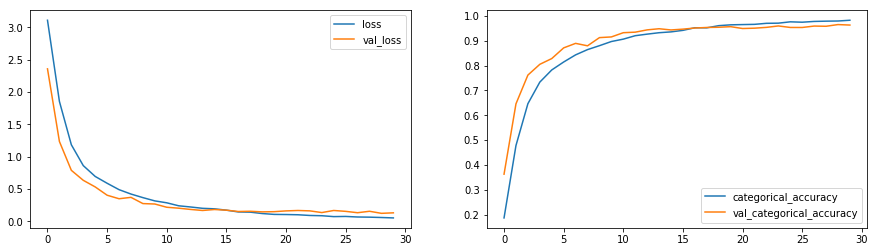

In [ ]:
plot(history)